In [1]:
# =========================
# Cell 1 — Imports
# =========================

using LinearAlgebra
using Statistics
using Distributions
using Printf
using Parameters
using Base.Threads

In [2]:
# =========================
# Cell 2 — Structs (Unskilled block)
# =========================

@with_kw struct UnskilledParams
    # Discounting and aggregate CTMC
    r::Float64
    Q::Matrix{Float64}                 # K×K generator
    K::Int                             # number of aggregate states

    # Matching technology (Cobb–Douglas)
    muU::Float64                       # μ_U
    etaU::Float64                      # η_U ∈ (0,1)

    # Shocks / separation (unskilled idiosyncratic shocks)
    lambdaU::Float64                   # λ_U

    # Vacancy posting cost
    kU::Float64                        # k_U

    # Bargaining
    betaU::Float64                     # β_U ∈ (0,1)

    # Training
    phi::Float64                       # φ

    # Aggregate-state-dependent flows and productivity shifters (length K)
    bU::Vector{Float64}                # b_U(z)
    bT::Vector{Float64}                # b_T(z)
    PU::Vector{Float64}                # P_U(z)
end

@with_kw struct XGrid
    # Worker type grid
    x::Vector{Float64}                 # length Nx, assumed sorted ascending
    Nx::Int                            # number of grid points

    # Distribution for x and its CDF evaluated on the grid
    dist::Beta                         # Beta(a_x, b_x)
    Lcdf::Vector{Float64}              # L(x_i), length Nx

    # Discrete measure increments for dL on the grid:
    # ΔL[i] ≈ L(x_i) - L(x_{i-1}) with ΔL[1] = L(x_1)
    dL::Vector{Float64}                # length Nx
end

@with_kw struct UnskilledInputs
    # Policy / equilibrium inputs coming from outside the unskilled block
    xbar::Vector{Float64}              # upper end of support AND training cutoff, length K

    # Training cost evaluated on the x-grid
    c::Vector{Float64}                 # length Nx

    # Skilled-unemployment value on the (x,z) grid
    US::Matrix{Float64}                # Nx×K
end

@with_kw mutable struct UnskilledSolution
    # Core equilibrium objects by aggregate state
    theta::Vector{Float64}             # θ_U(z), length K
    xr::Vector{Float64}                # reservation productivity x_r(z), length K
    ir::Vector{Int}                    # index of x_r(z) on grid (smallest i with x[i] ≥ x_r), length K
    Usearch::Vector{Float64}           # U_U^{search}(z), length K

    # Value functions on the full grid (entries outside active region may be set to 0.0)
    T::Matrix{Float64}                 # Nx×K
    J::Matrix{Float64}                 # Nx×K
    E::Matrix{Float64}                 # Nx×K

    # Constructed unemployment value (max rule), Nx×K
    U::Matrix{Float64}                 # Nx×K

    # Diagnostics
    converged::Bool
    iters::Int
    maxerr::Float64
end

@with_kw mutable struct UnskilledCache
    # Grid index for xbar(z)
    ibar::Vector{Int}                  # length K

    # Active index ranges per z (ir[z]:ibar[z])
    active::Vector{UnitRange{Int}}     # length K

    # Scratch space to avoid allocations in loops
    tmp_vecN::Vector{Float64}          # length Nx (generic)
    tmp_vecK::Vector{Float64}          # length K  (generic)
end

@with_kw mutable struct UnskilledModel
    par::UnskilledParams
    grid::XGrid
    inp::UnskilledInputs
    sol::UnskilledSolution
    cache::UnskilledCache
end

UnskilledModel

In [3]:
# =========================
# Cell 3 — Utilities and grid / distribution preparation
# =========================

# ---- Index helpers ----

"""
    first_geq(xgrid, x)

Return the smallest index i such that xgrid[i] ≥ x.
Assumes xgrid is sorted ascending.
Clamps to [1, length(xgrid)].
"""
function first_geq(xgrid::Vector{Float64}, x::Float64)
    i = searchsortedfirst(xgrid, x)
    return clamp(i, 1, length(xgrid))
end

"""
    last_leq(xgrid, x)

Return the largest index i such that xgrid[i] ≤ x.
Assumes xgrid is sorted ascending.
Clamps to [1, length(xgrid)].
"""
function last_leq(xgrid::Vector{Float64}, x::Float64)
    i = searchsortedlast(xgrid, x)
    return clamp(i, 1, length(xgrid))
end

# ---- Trapezoidal grid on [0,1] ----

"""
    make_xgrid(Nx)

Construct an evenly spaced grid on [0,1] with Nx points.
"""
function make_xgrid(Nx::Int)
    @assert Nx ≥ 2
    return collect(range(0.0, 1.0; length = Nx))
end

# ---- Beta distribution preparation using CDF only ----

"""
    prepare_xgrid_beta(xgrid, a, b)

Given an x-grid and Beta(a,b), return:
- dist  : Beta(a,b)
- Lcdf  : CDF evaluated at grid points
- dL    : discrete probability mass increments ΔL

Uses only the CDF to avoid PDF singularities when a<1 or b<1.
"""
function prepare_xgrid_beta(xgrid::Vector{Float64}, a::Float64, b::Float64)
    dist = Beta(a, b)
    Nx = length(xgrid)

    Lcdf = similar(xgrid)
    for i in 1:Nx
        Lcdf[i] = cdf(dist, xgrid[i])
    end

    dL = similar(xgrid)
    dL[1] = Lcdf[1]
    for i in 2:Nx
        dL[i] = Lcdf[i] - Lcdf[i-1]
    end

    return dist, Lcdf, dL
end

prepare_xgrid_beta

In [4]:
# =========================
# Cell 4 — initialize_unskilled
# =========================

"""
    initialize_unskilled(; kwargs...)

Create and return a fully allocated UnskilledModel.
No placeholders: all arrays are allocated at correct sizes.
"""
function initialize_unskilled(;
    # Aggregate environment
    r::Float64,
    Q::Matrix{Float64},

    # Matching / technology
    muU::Float64,
    etaU::Float64,
    lambdaU::Float64,
    kU::Float64,
    betaU::Float64,

    # Training
    phi::Float64,

    # Aggregate-state-dependent objects (length K)
    bU::Vector{Float64},
    bT::Vector{Float64},
    PU::Vector{Float64},

    # x-grid and distribution
    Nx::Int,
    beta_a::Float64,
    beta_b::Float64,

    # Training cutoff / upper support
    xbar::Vector{Float64},

    # Training cost function c(x)
    c_fun::Function,

    # Skilled unemployment value on grid
    US::Matrix{Float64}
)

    # -------------------------
    # Dimensions and checks
    # -------------------------
    K = size(Q, 1)
    @assert size(Q, 2) == K
    @assert length(bU) == K
    @assert length(bT) == K
    @assert length(PU) == K
    @assert length(xbar) == K
    @assert size(US, 2) == K

    # -------------------------
    # Parameters
    # -------------------------
    par = UnskilledParams(
        r = r,
        Q = Q,
        K = K,
        muU = muU,
        etaU = etaU,
        lambdaU = lambdaU,
        kU = kU,
        betaU = betaU,
        phi = phi,
        bU = bU,
        bT = bT,
        PU = PU
    )

    # -------------------------
    # x-grid and distribution
    # -------------------------
    xgrid = make_xgrid(Nx)
    dist, Lcdf, dL = prepare_xgrid_beta(xgrid, beta_a, beta_b)

    grid = XGrid(
        x = xgrid,
        Nx = Nx,
        dist = dist,
        Lcdf = Lcdf,
        dL = dL
    )

    # -------------------------
    # Inputs
    # -------------------------
    c_vec = similar(xgrid)
    for i in 1:Nx
        c_vec[i] = c_fun(xgrid[i])
    end

    inp = UnskilledInputs(
        xbar = xbar,
        c = c_vec,
        US = US
    )

    # -------------------------
    # Allocate solution objects
    # -------------------------
    theta = fill(1.0, K)
    xr = fill(0.0, K)
    ir = fill(1, K)
    Usearch = zeros(K)

    T = zeros(Nx, K)
    J = zeros(Nx, K)
    E = zeros(Nx, K)
    U = zeros(Nx, K)

    sol = UnskilledSolution(
        theta = theta,
        xr = xr,
        ir = ir,
        Usearch = Usearch,
        T = T,
        J = J,
        E = E,
        U = U,
        converged = false,
        iters = 0,
        maxerr = Inf
    )

    # -------------------------
    # Cache
    # -------------------------
    ibar = similar(ir)
    active = Vector{UnitRange{Int}}(undef, K)

    for z in 1:K
        ib = first_geq(xgrid, xbar[z])
        ibar[z] = ib
        active[z] = 1:ib   # initial guess: no endogenous destruction
    end

    cache = UnskilledCache(
        ibar = ibar,
        active = active,
        tmp_vecN = zeros(Nx),
        tmp_vecK = zeros(K)
    )

    return UnskilledModel(
        par = par,
        grid = grid,
        inp = inp,
        sol = sol,
        cache = cache
    )
end

initialize_unskilled

In [5]:
# =========================
# Cell 5 — Training step and inner-loop solvers (Usearch separate from J/E)
# =========================

# ------------------------------------------------------------
# Small linear-operator helper: compute (rI - Q) * v without allocating I
# ------------------------------------------------------------
function apply_r_minus_Q(par::UnskilledParams, v::Vector{Float64})
    # returns r*v - Q*v
    return par.r .* v .- par.Q * v
end

# ------------------------------------------------------------
# Matching rates
# ------------------------------------------------------------
qU(par::UnskilledParams, θ::Float64) = par.muU * θ^(-par.etaU)
jobfindU(par::UnskilledParams, θ::Float64) = θ * qU(par, θ)

# Truncated CDF at xr:  L̃(xr) = L(xr) / L(xbar)
function Ltrunc_at_xr(model::UnskilledModel, z::Int)
    grid, cache, sol = model.grid, model.cache, model.sol
    ib = cache.ibar[z]
    ir = sol.ir[z]
    Lbar = grid.Lcdf[ib]
    @assert Lbar > 0.0
    return grid.Lcdf[ir] / Lbar
end

# ------------------------------------------------------------
# Truncated dL on [0, xbar(z)] using only CDF increments
# We store dL on [0,1] in grid.dL, then renormalize per z by L(xbar(z)).
# ------------------------------------------------------------
function dL_trunc(grid::XGrid, cache::UnskilledCache, z::Int)
    ib = cache.ibar[z]
    Lbar = grid.Lcdf[ib]
    @assert Lbar > 0.0
    # returns a view-like triple (range, normalization scalar)
    return 1:ib, (1.0 / Lbar)
end

# ------------------------------------------------------------
# Expectation over x under truncated distribution and active region
# E_z[V] = ∫_{xr(z)}^{xbar(z)} V(x) dL̃(x), where L̃ is Beta truncated to [0,xbar(z)]
# V is provided as a Vector over the x-grid (length Nx) for a fixed z.
# ------------------------------------------------------------
function expect_active_trunc(Vz::AbstractVector{Float64}, model::UnskilledModel, z::Int)
    grid, cache = model.grid, model.cache
    ir = model.sol.ir[z]
    ib = cache.ibar[z]

    if ir > ib
        return 0.0
    end

    Lbar = grid.Lcdf[ib]
    @assert Lbar > 0.0
    invLbar = 1.0 / Lbar

    s = 0.0
    @inbounds for i in ir:ib
        s += Vz[i] * grid.dL[i]
    end
    return s * invLbar
end

# ------------------------------------------------------------
# (1) solve_training! : solve T(x,z) for all x given US(x,z)
# For each x_i:  [ (r+φ)I - Q ] * T_i = bT + φ * US_i
# ------------------------------------------------------------
function solve_training!(model::UnskilledModel)
    par, grid, inp, sol = model.par, model.grid, model.inp, model.sol
    K, Nx = par.K, grid.Nx

    A = (par.r + par.phi) * I(K) - par.Q
    F = lu(Matrix(A))  # factor once; safe to share read-only

    # One rhs and one tmp per thread to avoid races and allocations
    rhs_threads = [zeros(K) for _ in 1:nthreads()]
    tmp_threads = [zeros(K) for _ in 1:nthreads()]

    @threads for i in 1:Nx
        tid = threadid()
        rhs = rhs_threads[tid]
        tmp = tmp_threads[tid]

        # rhs = bT + phi * US[i,:]
        @views rhs .= par.bT .+ par.phi .* inp.US[i, :]

        # tmp = F \ rhs (in-place solve)
        ldiv!(tmp, F, rhs)

        # write result
        @views sol.T[i, :] .= tmp
    end

    return nothing
end

# ------------------------------------------------------------
# (2) solve_usearch_star! : solve Usearch(z) using equation (*) with outside option U(x,z)
#
# Fixed point:
#   ((r - Q) + D) Usearch = bU + D .* Ubar + coef*kU*theta
# where D[z] = θ[z] q(θ[z]) and Ubar[z] = U(xbar(z), z) = max{Usearch[z], -c(xbar)+T(xbar,z)}.
#
# We iterate on Usearch because Ubar depends on it through the max operator.
# ------------------------------------------------------------
function solve_usearch_star!(model::UnskilledModel;
    tol::Float64 = 1e-12,
    maxiter::Int = 10_000,
    damp::Float64 = 1.0
)
    par, grid, inp, sol, cache = model.par, model.grid, model.inp, model.sol, model.cache
    K = par.K
    @assert 0.0 < damp ≤ 1.0

    # Precompute d(z)=θ q(θ)
    d = cache.tmp_vecK
    @inbounds for z in 1:K
        d[z] = jobfindU(par, sol.theta[z])  # θ*q(θ)
    end

    coef = (par.betaU / (1.0 - par.betaU)) * par.kU

    # Iteration storage
    U_old = copy(sol.Usearch)
    rhs = zeros(K)
    Ubar = zeros(K)

    err = Inf
    it = 0
    while (err > tol) && (it < maxiter)
        it += 1

        # Compute Ubar(z) at xbar(z) using current guess of Usearch
        @inbounds for z in 1:K
            ib = cache.ibar[z]                    # index of xbar(z) on grid
            train_val = -inp.c[ib] + sol.T[ib, z]
            Ubar[z] = max(U_old[z], train_val)
        end

        # Build and solve linear system: ((r - Q) + Diag(d)) U = bU + d.*Ubar + coef*theta
        A = par.r * I(K) - par.Q + Diagonal(d)
        F = lu(Matrix(A))  # K small; factor each iteration is ok

        @inbounds for z in 1:K
            rhs[z] = par.bU[z] + d[z] * Ubar[z] + coef * sol.theta[z]
        end

        U_new = F \ rhs

        # Damped update + error
        err = 0.0
        @inbounds for z in 1:K
            u = damp * U_new[z] + (1.0 - damp) * U_old[z]
            err = max(err, abs(u - U_old[z]))
            U_old[z] = u
        end
    end

    sol.Usearch .= U_old
    sol.maxerr = err
    return nothing
end

# ------------------------------------------------------------
# (3) build_U! : construct unemployment value U(x,z) = max{Usearch(z), -c(x)+T(x,z)}
# (You asked for U separate from J/E; this is the pointwise max construction.)
# ------------------------------------------------------------
function build_U!(model::UnskilledModel)
    grid, inp, sol, par = model.grid, model.inp, model.sol, model.par
    Nx, K = grid.Nx, par.K

    @inbounds for z in 1:K
        U0 = sol.Usearch[z]
        @inbounds for i in 1:Nx
            val_train = -inp.c[i] + sol.T[i, z]
            sol.U[i, z] = max(U0, val_train)
        end
    end
    return nothing
end
# ------------------------------------------------------------
# (4) solve_HJE_given_theta_xr! : inner solve when outside option is U(x,z)
#
# Steps:
# 1) Treat U(x,z) as given (already built by build_U!)
# 2) Solve fixed point for joint value H = J + E:
#       A * H(x_i,·) = PU(·)*x_i + λ*( EU0 + EH )
#    where:
#       A = ((r+λ)I - Q)
#       EU0[z] = ∫_0^{xr(z)} U(x',z) dL̃_z
#       EH[z]  = ∫_{xr(z)}^{xbar(z)} H(x',z) dL̃_z
# 3) Recover J and E:
#       J = (1-β)(H - U)
#       E = U + (β/(1-β)) J
# ------------------------------------------------------------
function solve_HJE_given_theta_xr!(model::UnskilledModel;
    tol::Float64 = 1e-10,
    maxiter::Int = 50_000,
    damp::Float64 = 0.7
)
    par, grid, sol, cache, inp = model.par, model.grid, model.sol, model.cache, model.inp
    K, Nx = par.K, grid.Nx
    @assert 0.0 < damp ≤ 1.0

    # Refresh ibar and ir from current xr and xbar
    @inbounds for z in 1:K
        cache.ibar[z] = first_geq(grid.x, inp.xbar[z])
        sol.ir[z] = first_geq(grid.x, sol.xr[z])
        sol.ir[z] = clamp(sol.ir[z], 1, cache.ibar[z])
        cache.active[z] = sol.ir[z]:cache.ibar[z]
    end

    A = (par.r + par.lambdaU) * I(K) - par.Q
    F = lu(Matrix(A))

    β = par.betaU
    one_minus_β = 1.0 - β
    β_over_1mβ = β / one_minus_β

    # Fixed point objects: EH[z] = ∫_{xr}^{xbar} H dL̃
    EH = zeros(K)
    EH_new = zeros(K)

    # EU0[z] = ∫_{0}^{xr} U dL̃  (depends only on U and xr, not on H)
    EU0 = zeros(K)

    # Compute EU0 once per call (given current U and xr)
    @inbounds for z in 1:K
        ib = cache.ibar[z]
        ir = sol.ir[z]
        Lbar = grid.Lcdf[ib]
        @assert Lbar > 0.0
        invLbar = 1.0 / Lbar

        s = 0.0
        if ir ≥ 2
            @inbounds for i in 1:(ir-1)
                s += sol.U[i, z] * grid.dL[i]
            end
        end
        EU0[z] = s * invLbar
    end

    rhs = zeros(K)

    err = Inf
    it = 0
    while (err > tol) && (it < maxiter)
        it += 1

        # Given EH, solve H(x_i,·) for all i
        @inbounds for i in 1:Nx
            xi = grid.x[i]
            @inbounds for z in 1:K
                rhs[z] = par.PU[z] * xi + par.lambdaU * (EU0[z] + EH[z])
            end

            Hi = F \ rhs  # K-vector

            # Temporarily store H in sol.E (we will overwrite with worker E at the end)
            @inbounds for z in 1:K
                sol.E[i, z] = Hi[z]
            end
        end

        # Enforce outside support x > xbar : set H=0 (and hence J=0, E will be set later)
        @inbounds for z in 1:K
            ib = cache.ibar[z]
            if ib < Nx
                @inbounds for i in (ib+1):Nx
                    sol.E[i, z] = 0.0  # H
                end
            end
        end

        # Update EH from stored H (in sol.E) using truncated measure and active region
        @inbounds for z in 1:K
            ir = sol.ir[z]
            ib = cache.ibar[z]
            if ir > ib
                EH_new[z] = 0.0
                continue
            end

            Lbar = grid.Lcdf[ib]
            @assert Lbar > 0.0
            invLbar = 1.0 / Lbar

            s = 0.0
            @inbounds for i in ir:ib
                s += sol.E[i, z] * grid.dL[i]   # sol.E holds H here
            end
            EH_new[z] = s * invLbar
        end

        # Damped update + convergence
        err = 0.0
        @inbounds for z in 1:K
            old = EH[z]
            new = damp * EH_new[z] + (1.0 - damp) * old
            EH[z] = new
            err = max(err, abs(new - old))
        end
    end

    # Recover J and true worker E using H stored in sol.E and U stored in sol.U
    @inbounds for z in 1:K
        ib = cache.ibar[z]
        @inbounds for i in 1:ib
            H = sol.E[i, z]
            U = sol.U[i, z]
            J = one_minus_β * (H - U)
            sol.J[i, z] = J
            sol.E[i, z] = U + β_over_1mβ * J   # overwrite sol.E with worker E
        end
        if ib < Nx
            @inbounds for i in (ib+1):Nx
                sol.J[i, z] = 0.0
                sol.E[i, z] = 0.0
            end
        end
    end

    sol.maxerr = err
    return nothing
end

solve_HJE_given_theta_xr! (generic function with 1 method)

In [6]:
# =========================
# Cell A — Test initialization (small, stable)
# =========================

# --- Aggregate states / CTMC ---
z_vals = [0.75, 1.0, 1.25]
K = length(z_vals)

q = 0.10
Q = [
    -2q    1.25q  0.75q
     q    -2q      q
     0.75q 1.25q  -2q
]

# --- Primitives ---
r       = 0.05
muU     = 0.05
etaU    = 0.50
lambdaU = 0.12
kU      = 0.10
betaU   = 0.30
phi     = 0.15

bU = 0.15 .* z_vals
bT = 0.15 .* z_vals
PU = 1.00 .* z_vals

# --- x-grid / Beta distribution ---
Nx = 201
beta_a = 2.0
beta_b = 5.0

# --- Training cutoff / upper support xbar(z) ---
# (As an input, not endogenized here.)
xbar = [0.22, 0.20, 0.18]

# --- Training cost c(x) ---
c_fun(x) = 3.0 * exp(-x)

# --- Skilled unemployment value U_S(x,z) ---
xgrid_tmp = collect(range(0.0, 1.0; length = Nx))
US = zeros(Nx, K)
for z in 1:K
    for i in 1:Nx
        US[i, z] = 1.0 + 10.0 * z_vals[z] * xgrid_tmp[i]
    end
end

# --- Initialize model ---
model = initialize_unskilled(
    r = r,
    Q = Q,
    muU = muU,
    etaU = etaU,
    lambdaU = lambdaU,
    kU = kU,
    betaU = betaU,
    phi = phi,
    bU = bU,
    bT = bT,
    PU = PU,
    Nx = Nx,
    beta_a = beta_a,
    beta_b = beta_b,
    xbar = xbar,
    c_fun = c_fun,
    US = US
)

println("Initialized UnskilledModel with K=$K, Nx=$Nx")
println("xbar (input): ", model.inp.xbar)
println("Initial theta: ", model.sol.theta, "   initial xr: ", model.sol.xr)

Initialized UnskilledModel with K=3, Nx=201
xbar (input): [0.22, 0.2, 0.18]
Initial theta: [1.0, 1.0, 1.0]   initial xr: [0.0, 0.0, 0.0]


In [7]:
# =========================
# Cell B — One-pass step-through with useful prints
# =========================

par, grid, inp, sol, cache = model.par, model.grid, model.inp, model.sol, model.cache
K, Nx = par.K, grid.Nx

println("\n--- Step 0: grid/index sanity ---")
for z in 1:K
    cache.ibar[z] = first_geq(grid.x, inp.xbar[z])  # ensure consistent
    ib = cache.ibar[z]
    println("z=$z  xbar=$(inp.xbar[z])  ibar=$ib  grid.x[ibar]=$(grid.x[ib])  L(xbar)=$(grid.Lcdf[ib])")
end
println("Check: dL sum on full grid = ", sum(grid.dL), " (should be ~1)")

# Optional: ensure theta/xr starting points are clear
println("\nInitial guesses:")
println("theta = ", sol.theta)
println("xr    = ", sol.xr, "   ir = ", sol.ir)

# ------------------------------------------------------------
# Step 1 — Training values T(x,z)
# ------------------------------------------------------------
println("\n--- Step 1: solve_training! ---")
solve_training!(model)

# Print T at a few x points for each z
ix_list = [1, Int(round(Nx/2)), Nx]
for z in 1:K
    vals = [(grid.x[i], sol.T[i,z]) for i in ix_list]
    println("z=$z  T(x,z) at x={0,0.5,1} approx: ", vals)
end

# ------------------------------------------------------------
# Step 2 — Solve Usearch(z) from (*) conditional on theta and T
# ------------------------------------------------------------
println("\n--- Step 2: solve_usearch_star! ---")
# set a nontrivial theta so Usearch has something to react to
sol.theta .= [0.5, 1.0, 2.0]
println("theta (set for test) = ", sol.theta)

solve_usearch_star!(model; tol=1e-12, maxiter=50_000, damp=0.8)

println("Usearch(z) = ", sol.Usearch, "   (inner err = ", sol.maxerr, ")")

# Print Ubar(z) = U(xbar,z) = max{Usearch, -c(xbar)+T(xbar)}
println("Implied Ubar(z) at xbar (max{Usearch, -c+T}):")
for z in 1:K
    ib = cache.ibar[z]
    train_val = -inp.c[ib] + sol.T[ib, z]
    Ubar = max(sol.Usearch[z], train_val)
    println("z=$z  xbar=$(grid.x[ib])  Usearch=$(sol.Usearch[z])  (-c+T)=$(train_val)  Ubar=$(Ubar)")
end

# ------------------------------------------------------------
# Step 3 — Build full unemployment value U(x,z)
# ------------------------------------------------------------
println("\n--- Step 3: build_U! ---")
build_U!(model)

# Print how often training is optimal on the grid (diagnostic, not an equilibrium mass)
for z in 1:K
    count_train = 0
    for i in 1:Nx
        if (-inp.c[i] + sol.T[i,z]) >= sol.Usearch[z]
            count_train += 1
        end
    end
    println("z=$z  #gridpoints where training dominates = $count_train / $Nx")
end

# ------------------------------------------------------------
# Step 4 — Solve H/J/E given theta and xr (single pass; xr initial is 0)
# ------------------------------------------------------------
println("\n--- Step 4: solve_HJE_given_theta_xr! ---")
# pick a nontrivial xr to test truncation logic
sol.xr .= [0.05, 0.08, 0.10]
println("xr (set for test) = ", sol.xr)

solve_HJE_given_theta_xr!(model; tol=1e-10, maxiter=200_000, damp=0.7)
println("HJE inner err (EH fixed point) = ", sol.maxerr)

# Print key boundary objects: J(xbar,z), J around xr, and implied theta condition objects
for z in 1:K
    ib = cache.ibar[z]
    ir = sol.ir[z]
    println("\nState z=$z:")
    println("  ibar=$ib  xbar=$(grid.x[ib])  ir=$ir  xr=$(grid.x[ir])")
    println("  J(xbar,z) = ", sol.J[ib,z], "   E(xbar,z) = ", sol.E[ib,z], "   U(xbar,z) = ", sol.U[ib,z])
    println("  J(xr,z)   = ", sol.J[ir,z], "   E(xr,z)   = ", sol.E[ir,z], "   U(xr,z)   = ", sol.U[ir,z])
    if ir > 1
        println("  J(just below xr) = ", sol.J[ir-1,z], " at x=", grid.x[ir-1])
    end
end

# ------------------------------------------------------------
# Step 5 — Verify the truncated-measure decomposition at xr (sanity check)
# ------------------------------------------------------------
println("\n--- Step 5: truncation sanity at xr ---")
for z in 1:K
    ib = cache.ibar[z]
    ir = sol.ir[z]
    Lbar = grid.Lcdf[ib]
    invLbar = 1.0 / Lbar
    mass_below = (ir >= 2) ? sum(grid.dL[1:ir-1]) * invLbar : 0.0
    mass_above = sum(grid.dL[ir:ib]) * invLbar
    println("z=$z  mass below xr (trunc) = $(mass_below)  mass above xr (trunc) = $(mass_above)  sum=$(mass_below+mass_above)")
end

println("\nDone: you have now executed training → Usearch(*) → U=max → H/J/E once, with diagnostic prints.")


--- Step 0: grid/index sanity ---
z=1  xbar=0.22  ibar=45  grid.x[ibar]=0.22  L(xbar)=0.39369338272
z=2  xbar=0.2  ibar=41  grid.x[ibar]=0.2  L(xbar)=0.34464000000000017
z=3  xbar=0.18  ibar=37  grid.x[ibar]=0.18  L(xbar)=0.29559429792000014
Check: dL sum on full grid = 1.0 (should be ~1)

Initial guesses:
theta = [1.0, 1.0, 1.0]
xr    = [0.0, 0.0, 0.0]   ir = [1, 1, 1]

--- Step 1: solve_training! ---
z=1  T(x,z) at x={0,0.5,1} approx: [(0.0, 1.421052631578947), (0.495, 4.742763157894736), (1.0, 8.13157894736842)]
z=2  T(x,z) at x={0,0.5,1} approx: [(0.0, 1.4999999999999998), (0.495, 5.2124999999999995), (1.0, 8.999999999999998)]
z=3  T(x,z) at x={0,0.5,1} approx: [(0.0, 1.5789473684210524), (0.495, 5.682236842105262), (1.0, 9.868421052631577)]

--- Step 2: solve_usearch_star! ---
theta (set for test) = [0.5, 1.0, 2.0]
Usearch(z) = [3.7857142857130865, 3.97142857142731, 4.214285714284358]   (inner err = 8.677503160470224e-13)
Implied Ubar(z) at xbar (max{Usearch, -c+T}):
z=1  xbar=0.

In [8]:
# =========================
# Cell 6 — Outer loop: solve_unskilled! (returns equilibrium objects)
# =========================

# ------------------------------------------------------------
# Update rule for x_r(z): grid-based boundary J(x_r,z) = 0
# We set ir[z] = smallest i in 1:ibar[z] such that J[i,z] ≥ 0.
# If no such i exists, set ir[z] = ibar[z] and xr[z] = x[ibar[z]] (corner).
# ------------------------------------------------------------
function update_xr!(model::UnskilledModel)
    grid, sol, cache, par = model.grid, model.sol, model.cache, model.par
    Nx, K = grid.Nx, par.K

    @inbounds for z in 1:K
        ib = cache.ibar[z]
        @assert 1 ≤ ib ≤ Nx

        new_ir = ib
        found = false
        @inbounds for i in 1:ib
            if sol.J[i, z] ≥ 0.0
                new_ir = i
                found = true
                break
            end
        end

        if !found
            new_ir = ib
        end

        sol.ir[z] = new_ir
        sol.xr[z] = grid.x[new_ir]
        cache.active[z] = new_ir:ib
    end
    return nothing
end

# ------------------------------------------------------------
# Update rule for theta(z): free entry at xbar(z)
# J(xbar,z) = kU / q(theta) = (kU/muU) * theta^etaU  =>  theta = ((muU/kU)*Jbar)^(1/etaU)
# We clamp to a small positive number to avoid θ=0 pathologies.
# ------------------------------------------------------------
function update_theta!(model::UnskilledModel; θ_min::Float64=1e-10, θ_max::Float64=1e10)
    par, sol, cache = model.par, model.sol, model.cache
    K = par.K

    @inbounds for z in 1:K
        ib = cache.ibar[z]
        Jbar = sol.J[ib, z]
        Jbar_pos = max(Jbar, 0.0)
        θ = ((par.muU / par.kU) * Jbar_pos)^(1.0 / par.etaU)
        sol.theta[z] = clamp(θ, θ_min, θ_max)
    end
    return nothing
end

# ------------------------------------------------------------
# Main solver
# - Solves training once (depends only on US and primitives)
# - Outer loop over {theta(z), xr(z)}:
#     1) solve Usearch given theta
#     2) build U(x,z)
#     3) solve J/E given theta and xr
#     4) update xr from J
#     5) update theta from free entry
#
# Returns a NamedTuple of equilibrium objects (and keeps them in model.sol).
# ------------------------------------------------------------
function solve_unskilled!(model::UnskilledModel;
    tol::Float64=1e-8,
    maxiter::Int=1_000,
    damp_theta::Float64=0.7,
    damp_xr::Float64=0.7,
    inner_tol::Float64=1e-10,
    inner_maxiter::Int=50_000,
    inner_damp::Float64=0.7,
    verbose::Bool=true
)

    par, grid, inp, sol, cache = model.par, model.grid, model.inp, model.sol, model.cache
    K, Nx = par.K, grid.Nx
    @assert 0.0 < damp_theta ≤ 1.0
    @assert 0.0 < damp_xr ≤ 1.0

    # Refresh ibar from xbar (fixed input here)
    @inbounds for z in 1:K
        cache.ibar[z] = first_geq(grid.x, inp.xbar[z])
        cache.active[z] = 1:cache.ibar[z]
    end

    # Training step (independent of theta/xr)
    solve_training!(model)

    # Initialize xr and ir consistently (start with no endogenous destruction)
    @inbounds for z in 1:K
        sol.xr[z] = 0.0
        sol.ir[z] = 1
        cache.active[z] = 1:cache.ibar[z]
    end

    # Outer loop
    maxerr = Inf
    it = 0

    θ_old = copy(sol.theta)
    xr_old = copy(sol.xr)

    while (maxerr > tol) && (it < maxiter)
        it += 1
        
        # 1) Given theta and T, solve Usearch(z) using equation (*)
        solve_usearch_star!(model; tol=inner_tol, maxiter=10_000, damp=0.8)

        # 2) Build unemployment value U(x,z)
        build_U!(model)

        # 3) Given theta, xr, and U, solve H/J/E (inner fixed point in EH)
        solve_HJE_given_theta_xr!(model; tol=inner_tol, maxiter=inner_maxiter, damp=inner_damp)

        # Save current as "old" for damping/error
        @inbounds for z in 1:K
            θ_old[z] = sol.theta[z]
            xr_old[z] = sol.xr[z]
        end

        # 4) Update xr from the boundary condition J(xr,z)=0 (grid-based)
        update_xr!(model)

        # Damping for xr update
        @inbounds for z in 1:K
            new_xr = sol.xr[z]
            sol.xr[z] = damp_xr * new_xr + (1.0 - damp_xr) * xr_old[z]
            sol.ir[z] = first_geq(grid.x, sol.xr[z])
            ib = cache.ibar[z]
            sol.ir[z] = clamp(sol.ir[z], 1, ib)
            sol.xr[z] = grid.x[sol.ir[z]]
            cache.active[z] = sol.ir[z]:ib
        end

        # 5) Update theta from free entry at xbar
        update_theta!(model)

        # Damping for theta update
        @inbounds for z in 1:K
            new_θ = sol.theta[z]
            sol.theta[z] = damp_theta * new_θ + (1.0 - damp_theta) * θ_old[z]
        end

        # Convergence metric: max change across z in theta and xr
        maxΔθ = 0.0
        maxΔxr = 0.0
        @inbounds for z in 1:K
            maxΔθ = max(maxΔθ, abs(sol.theta[z] - θ_old[z]))
            maxΔxr = max(maxΔxr, abs(sol.xr[z] - xr_old[z]))
        end
        maxerr = max(maxΔθ, maxΔxr)

        if verbose && (it == 1 || it % 10 == 0 || maxerr ≤ tol)
            @printf("outer it=%d  maxerr=%.3e  (maxΔθ=%.3e, maxΔxr=%.3e, inner_err=%.3e)\n",
                    it, maxerr, maxΔθ, maxΔxr, sol.maxerr)
        end
    end

    sol.converged = (maxerr ≤ tol)
    sol.iters = it
    sol.maxerr = maxerr

    # Return equilibrium objects as a NamedTuple (and keep them in model.sol)
    return (
        theta = copy(sol.theta),
        xr = copy(sol.xr),
        ir = copy(sol.ir),
        Usearch = copy(sol.Usearch),
        T = copy(sol.T),
        U = copy(sol.U),
        J = copy(sol.J),
        E = copy(sol.E),
        converged = sol.converged,
        iters = sol.iters,
        maxerr = sol.maxerr
    )
end

solve_unskilled! (generic function with 1 method)

In [9]:
function report_unskilled_masses(model::UnskilledModel)
    grid, sol, cache, inp, par = model.grid, model.sol, model.cache, model.inp, model.par
    K = par.K

    println("Unskilled masses and unemployment rates by z:")
    for z in 1:K
        ib = cache.ibar[z]      # index for xbar(z)
        ir = sol.ir[z]          # index for xr(z)

        xbar_z = grid.x[ib]
        xr_z   = grid.x[ir]

        L_xbar = grid.Lcdf[ib]  # mass below xbar
        L_xr   = grid.Lcdf[ir]  # mass below xr

        uU = (L_xbar > 0.0) ? (L_xr / L_xbar) : NaN  # unemployment rate within [0, xbar]

        println("z=$z  xbar=$(xbar_z)  xr=$(xr_z)  L(xbar)=$(L_xbar)  L(xr)=$(L_xr)  uU=L(xr)/L(xbar)=$(uU)")
    end
    return nothing
end

report_unskilled_masses (generic function with 1 method)

In [10]:
# =========================
# Cell 7 — Example usage with 3 aggregate states z ∈ {0.75, 1.0, 1.25}
# =========================


# ------------------------------------------------------------
# Aggregate states and CTMC
# ------------------------------------------------------------
z_vals = [0.75, 1.0, 1.25]
K = length(z_vals)

q = 0.10
Q = [
    -2q   1.25q    0.75q
     q  -2q    q
     0.75q    1.25q  -2q
]

# ------------------------------------------------------------
# Unskilled-side primitives (revised)
# ------------------------------------------------------------
r       = 0.05      
muU     = 0.022    # matching efficiency
etaU    = 0.40      # more stable curvature for q(theta)
lambdaU = 0.10     # more re-draws -> smoother J and less corner behavior
kU      = 0.10     # vacancy cost 
betaU   = 0.40     # worker bargaining weight
phi     = 0.15      # training completion rate

# Flow payoffs and productivity shifters by z
bU = 0.15 .* z_vals
bT = 0.15 .* z_vals
PU = 1.00 .* z_vals

# ------------------------------------------------------------
# x-grid and Beta distribution
# ------------------------------------------------------------
Nx = 201
beta_a = 2.0
beta_b = 5.0

# ------------------------------------------------------------
# Training cutoff / upper support x̄(z)
# ------------------------------------------------------------
xbar = [0.22, 0.20, 0.18]

# ------------------------------------------------------------
# Training cost function c(x)
# ------------------------------------------------------------
c_fun(x) = 3*exp(-x)

# ------------------------------------------------------------
# Skilled unemployment value U_S(x,z) (revised level and slope)
# Keep it materially above unskilled unemployment, but not orders of magnitude larger.
# ------------------------------------------------------------
xgrid_tmp = collect(range(0.0, 1.0; length = Nx))
US = zeros(Nx, K)
for z in 1:K
    for i in 1:Nx
        US[i, z] = 1.0 + 15.0 * z_vals[z] * xgrid_tmp[i]
    end
end

# ------------------------------------------------------------
# Initialize unskilled model
# ------------------------------------------------------------
model = initialize_unskilled(
    r = r,
    Q = Q,
    muU = muU,
    etaU = etaU,
    lambdaU = lambdaU,
    kU = kU,
    betaU = betaU,
    phi = phi,
    bU = bU,
    bT = bT,
    PU = PU,
    Nx = Nx,
    beta_a = beta_a,
    beta_b = beta_b,
    xbar = xbar,
    c_fun = c_fun,
    US = US
)

# ------------------------------------------------------------
# Solve unskilled equilibrium given x̄(·) and U_S
# ------------------------------------------------------------
eq = solve_unskilled!(
    model;
    tol = 1e-8,
    maxiter = 200,
    damp_theta = 0.3,
    damp_xr = 0.7,
    verbose = true
)

# ------------------------------------------------------------
# Inspect results
# ------------------------------------------------------------
println("Converged: ", eq.converged)
println("Iterations: ", eq.iters)
println("Market tightness θ(z): ", eq.theta)
println("Reservation productivity x_r(z): ", eq.xr)
println("Unemployment search value U_U^{search}(z): ", eq.Usearch)

report_unskilled_masses(model)

outer it=1  maxerr=3.000e-01  (maxΔθ=3.000e-01, maxΔxr=1.550e-01, inner_err=9.032e-11)
outer it=10  maxerr=1.208e-02  (maxΔθ=1.208e-02, maxΔxr=5.000e-03, inner_err=5.904e-11)
outer it=20  maxerr=3.395e-04  (maxΔθ=3.395e-04, maxΔxr=0.000e+00, inner_err=7.743e-11)
outer it=30  maxerr=9.538e-06  (maxΔθ=9.538e-06, maxΔxr=0.000e+00, inner_err=7.741e-11)
outer it=40  maxerr=2.680e-07  (maxΔθ=2.680e-07, maxΔxr=0.000e+00, inner_err=7.741e-11)
outer it=50  maxerr=7.529e-09  (maxΔθ=7.529e-09, maxΔxr=0.000e+00, inner_err=7.741e-11)
Converged: true
Iterations: 50
Market tightness θ(z): [0.0010863870920058672, 0.0006073072871494774, 0.00023080474037795234]
Reservation productivity x_r(z): [0.145, 0.15, 0.15]
Unemployment search value U_U^{search}(z): [2.885558479416591, 3.000846224818987, 3.116152206177814]
Unskilled masses and unemployment rates by z:
z=1  xbar=0.22  xr=0.145  L(xbar)=0.39369338272  L(xr)=0.21183041252195317  uU=L(xr)/L(xbar)=0.5380593675678055
z=2  xbar=0.2  xr=0.15  L(xbar)=0.34

In [11]:
# ============================================================
# Wrapper: endogenize xbar(z) via the training indifference condition
# Minimal intervention: calls your existing solve_unskilled! as-is.
# ============================================================

# Helper: implied xbar(z) from Usearch(z) = -c(x) + T(x,z)
# Returns (xbar_impl::Vector{Float64}, ibar_impl::Vector{Int})
function implied_xbar!(model::UnskilledModel)
    grid, sol, inp, par = model.grid, model.sol, model.inp, model.par
    Nx, K = grid.Nx, par.K

    xbar_impl = zeros(K)
    ibar_impl = ones(Int, K)

    @inbounds for z in 1:K
        target = sol.Usearch[z]
        idx = Nx
        @inbounds for i in 1:Nx
            if (-inp.c[i] + sol.T[i, z]) >= target
                idx = i
                break
            end
        end
        ibar_impl[z] = idx
        xbar_impl[z] = grid.x[idx]
    end

    return xbar_impl, ibar_impl
end

# Main wrapper:
# - iterates on inp.xbar (the cutoff / upper support used in the unskilled block)
# - each iteration:
#     1) updates model.inp.xbar
#     2) solves unskilled equilibrium using your existing solver
#     3) computes implied xbar from training indifference
#     4) damped update of xbar
#
# Notes:
# * This keeps your "outside option is Usearch only" assumption.
# * Training still only affects unskilled equilibrium through xbar.
# * You can clamp xbar in [xmin, xmax] to avoid pathological corners.
function solve_unskilled_with_endogenous_xbar!(
    model::UnskilledModel;
    tol_xbar::Float64 = 1e-6,
    maxiter_xbar::Int = 200,
    damp_xbar::Float64 = 0.3,
    xmin::Float64 = 1e-6,
    xmax::Float64 = 1.0 - 1e-6,
    verbose::Bool = true,
    # pass-through args to your existing solver:
    tol::Float64 = 1e-8,
    maxiter::Int = 500,
    damp_theta::Float64 = 0.3,
    damp_xr::Float64 = 0.7,
    inner_tol::Float64 = 1e-10,
    inner_maxiter::Int = 50_000,
    inner_damp::Float64 = 0.7
)
    par, inp = model.par, model.inp
    K = par.K
    @assert 0.0 < damp_xbar ≤ 1.0

    xbar_old = copy(inp.xbar)
    xbar_new = similar(inp.xbar)

    # Important: T depends only on US and primitives, not on xbar, so compute once.
    # (This matches your current solver logic.)
    solve_training!(model)

    it = 0
    maxΔ = Inf
    converged = false

    while (it < maxiter_xbar) && (maxΔ > tol_xbar)
        it += 1

        # 1) Solve unskilled block given current xbar (uses model.inp.xbar internally)
        eq = solve_unskilled!(
            model;
            tol = tol,
            maxiter = maxiter,
            damp_theta = damp_theta,
            damp_xr = damp_xr,
            inner_tol = inner_tol,
            inner_maxiter = inner_maxiter,
            inner_damp = inner_damp,
            verbose = false
        )

        # 2) Compute implied xbar from training indifference (grid-based)
        xbar_impl, _ = implied_xbar!(model)

        # 3) Damped update + clamp
        maxΔ = 0.0
        @inbounds for z in 1:K
            xbar_old[z] = inp.xbar[z]
            xnew = (1.0 - damp_xbar) * xbar_old[z] + damp_xbar * xbar_impl[z]
            xnew = clamp(xnew, xmin, xmax)
            xbar_new[z] = xnew
            maxΔ = max(maxΔ, abs(xbar_new[z] - xbar_old[z]))
        end

        inp.xbar .= xbar_new

        if verbose && (it == 1 || it % 10 == 0 || maxΔ ≤ tol_xbar)
            @printf("xbar it=%d  maxΔxbar=%.3e  xbar=%s  xbar_impl=%s  (inner iters=%d, converged=%s)\n",
                    it, maxΔ,
                    string(round.(xbar_old; digits=4)),
                    string(round.(xbar_impl; digits=4)),
                    eq.iters, string(eq.converged))
        end
    end

    converged = (maxΔ ≤ tol_xbar)

    # Final solve at converged xbar (so returned eq matches final xbar exactly)
    eq_final = solve_unskilled!(
        model;
        tol = tol,
        maxiter = maxiter,
        damp_theta = damp_theta,
        damp_xr = damp_xr,
        inner_tol = inner_tol,
        inner_maxiter = inner_maxiter,
        inner_damp = inner_damp,
        verbose = verbose
    )

    return (
        eq = eq_final,
        xbar = copy(model.inp.xbar),
        converged_xbar = converged,
        iters_xbar = it,
        maxerr_xbar = maxΔ
    )
end

solve_unskilled_with_endogenous_xbar! (generic function with 1 method)

In [12]:
# =========================
# Cell 8 — Plotting functions for the unskilled block (colors keyed to z)
# Drop-in replacement for the entire plotting code
# =========================

using Plots

# ------------------------------------------------------------
# Internal: build a "masked" series that is NaN outside [1, ibar[z]]
# so plots do not draw lines where the object is undefined by construction.
# ------------------------------------------------------------
function _masked_upto_ibar(x::Vector{Float64}, y::AbstractVector{Float64}, ib::Int)
    n = length(x)
    out = Vector{Float64}(undef, n)
    @inbounds for i in 1:n
        out[i] = (i <= ib) ? y[i] : NaN
    end
    return out
end

# ------------------------------------------------------------
# Internal: consistent color per z across plots and series
# ------------------------------------------------------------
function _zcolor(z::Int)
    # uses current theme's palette; stable mapping z -> color
    pal = palette(:auto)
    return pal[(z - 1) % length(pal) + 1]
end

# ------------------------------------------------------------
# Plot J(x,z) for each aggregate state z
# ------------------------------------------------------------
function plot_J(model::UnskilledModel; title_str::String="Firm value J_U(x,z)")
    x = model.grid.x
    K = model.par.K

    plt = plot(title=title_str, xlabel="x", ylabel="J_U(x,z)", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)
        ib = model.cache.ibar[z]
        y = _masked_upto_ibar(x, view(model.sol.J, :, z), ib)

        plot!(plt, x, y; label="z=$z", color=col)

        # mark xbar and xr, keep same color but different linestyles
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)
        vline!(plt, [model.sol.xr[z]];   label=false, linestyle=:dot,  color=col)
    end
    hline!(plt, [0.0]; label=false, linestyle=:dashdot, color=:black)

    display(plt)
    return plt
end

# ------------------------------------------------------------
# Plot E(x,z) for each aggregate state z, plus Usearch(z) reference line
# ------------------------------------------------------------
function plot_E(model::UnskilledModel; title_str::String="Worker value E_U(x,z) and U_U^{search}(z)")
    x = model.grid.x
    K = model.par.K

    plt = plot(title=title_str, xlabel="x", ylabel="E_U(x,z)", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)
        ib = model.cache.ibar[z]
        yE = _masked_upto_ibar(x, view(model.sol.E, :, z), ib)

        plot!(plt, x, yE; label="z=$z (E)", color=col)

        # Usearch horizontal line for each z (same color)
        hline!(plt, [model.sol.Usearch[z]]; label="z=$z (Usearch)", linestyle=:dash, color=col)

        # mark xbar and xr (same color)
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)
        vline!(plt, [model.sol.xr[z]];   label=false, linestyle=:dot,  color=col)
    end

    display(plt)
    return plt
end

# ------------------------------------------------------------
# Plot the training option -c(x)+T(x,z) versus Usearch(z), showing cutoff xbar(z)
# Optionally plots U(x,z)=max{Usearch, -c+T} as an envelope.
# ------------------------------------------------------------
function plot_training_vs_search(model::UnskilledModel;
    show_envelope::Bool=true,
    title_str::String="Search vs training option: Usearch(z) vs -c(x)+T(x,z)"
)
    x = model.grid.x
    K = model.par.K
    c = model.inp.c
    n = length(x)

    plt = plot(title=title_str, xlabel="x", ylabel="value", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)

        # training option
        train = Vector{Float64}(undef, n)
        @inbounds for i in 1:n
            train[i] = -c[i] + model.sol.T[i, z]
        end

        plot!(plt, x, train; label="z=$z (-c+T)", color=col)

        # Usearch line (same color)
        hline!(plt, [model.sol.Usearch[z]]; label="z=$z (Usearch)", linestyle=:dash, color=col)

        # xbar marker (same color)
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)

        # envelope (same color, dotted)
        if show_envelope
            plot!(plt, x, view(model.sol.U, :, z); label="z=$z (U envelope)", linestyle=:dot, color=col)
        end
    end

    display(plt)
    return plt
end

# =========================
# Cell 8 — Plotting functions for the unskilled block (colors keyed to z)
# Drop-in replacement for the entire plotting code
# =========================

using Plots

# ------------------------------------------------------------
# Internal: build a "masked" series that is NaN outside [1, ibar[z]]
# so plots do not draw lines where the object is undefined by construction.
# ------------------------------------------------------------
function _masked_upto_ibar(x::Vector{Float64}, y::AbstractVector{Float64}, ib::Int)
    n = length(x)
    out = Vector{Float64}(undef, n)
    @inbounds for i in 1:n
        out[i] = (i <= ib) ? y[i] : NaN
    end
    return out
end

# ------------------------------------------------------------
# Internal: consistent color per z across plots and series
# ------------------------------------------------------------
function _zcolor(z::Int)
    # uses current theme's palette; stable mapping z -> color
    pal = palette(:auto)
    return pal[(z - 1) % length(pal) + 1]
end

# ------------------------------------------------------------
# Plot J(x,z) for each aggregate state z
# ------------------------------------------------------------
function plot_J(model::UnskilledModel; title_str::String="Firm value J_U(x,z)")
    x = model.grid.x
    K = model.par.K

    plt = plot(title=title_str, xlabel="x", ylabel="J_U(x,z)", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)
        ib = model.cache.ibar[z]
        y = _masked_upto_ibar(x, view(model.sol.J, :, z), ib)

        plot!(plt, x, y; label="z=$z", color=col)

        # mark xbar and xr, keep same color but different linestyles
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)
        vline!(plt, [model.sol.xr[z]];   label=false, linestyle=:dot,  color=col)
    end
    hline!(plt, [0.0]; label=false, linestyle=:dashdot, color=:black)

    display(plt)
    return plt
end

# ------------------------------------------------------------
# Plot E(x,z) for each aggregate state z, plus Usearch(z) reference line
# ------------------------------------------------------------
function plot_E(model::UnskilledModel; title_str::String="Worker value E_U(x,z) and U_U^{search}(z)")
    x = model.grid.x
    K = model.par.K

    plt = plot(title=title_str, xlabel="x", ylabel="E_U(x,z)", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)
        ib = model.cache.ibar[z]
        yE = _masked_upto_ibar(x, view(model.sol.E, :, z), ib)

        plot!(plt, x, yE; label="z=$z (E)", color=col)

        # Usearch horizontal line for each z (same color)
        hline!(plt, [model.sol.Usearch[z]]; label="z=$z (Usearch)", linestyle=:dash, color=col)

        # mark xbar and xr (same color)
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)
        vline!(plt, [model.sol.xr[z]];   label=false, linestyle=:dot,  color=col)
    end

    display(plt)
    return plt
end

# ------------------------------------------------------------
# Plot the training option -c(x)+T(x,z) versus Usearch(z), showing cutoff xbar(z)
# Optionally plots U(x,z)=max{Usearch, -c+T} as an envelope.
# ------------------------------------------------------------
function plot_training_vs_search(model::UnskilledModel;
    show_envelope::Bool=true,
    title_str::String="Search vs training option: Usearch(z) vs -c(x)+T(x,z)"
)
    x = model.grid.x
    K = model.par.K
    c = model.inp.c
    n = length(x)

    plt = plot(title=title_str, xlabel="x", ylabel="value", legend=:topright)
    @inbounds for z in 1:K
        col = _zcolor(z)

        # training option
        train = Vector{Float64}(undef, n)
        @inbounds for i in 1:n
            train[i] = -c[i] + model.sol.T[i, z]
        end

        plot!(plt, x, train; label="z=$z (-c+T)", color=col)

        # Usearch line (same color)
        hline!(plt, [model.sol.Usearch[z]]; label="z=$z (Usearch)", linestyle=:dash, color=col)

        # xbar marker (same color)
        vline!(plt, [model.inp.xbar[z]]; label=false, linestyle=:dash, color=col)

        # envelope (same color, dotted)
        if show_envelope
            plot!(plt, x, view(model.sol.U, :, z); label="z=$z (U envelope)", linestyle=:dot, color=col)
        end
    end

    display(plt)
    return plt
end

# ------------------------------------------------------------
# Plot equilibrium objects across aggregate states: theta(z), xr(z), Usearch(z)
# Uses z indices by default; you can pass z_values to label x-axis by actual z.
# ------------------------------------------------------------
function plot_equilibrium_objects(model::UnskilledModel; z_values::Union{Nothing,Vector{Float64}}=nothing)
    K = model.par.K
    xaxis = (z_values === nothing) ? collect(1:K) : z_values
    xlabel_str = (z_values === nothing) ? "z index" : "z"


    plt1 = plot(xaxis, model.sol.theta;
                marker=:circle, xlabel=xlabel_str, ylabel="θ_U(z)",
                title="Market tightness", legend=false)

    plt2 = plot(xaxis, model.sol.xr;
                marker=:circle, xlabel=xlabel_str, ylabel="x_r(z)",
                title="Reservation productivity", legend=false)

    plt3 = plot(xaxis, model.sol.Usearch;
                marker=:circle, xlabel=xlabel_str, ylabel="U_U^{search}(z)",
                title="Search unemployment value", legend=false)

    display(plt1); display(plt2); display(plt3)
    return (plt1=plt1, plt2=plt2, plt3=plt3)
end

plot_equilibrium_objects (generic function with 1 method)

In [13]:
# ------------------------------------------------------------
# Aggregate states and CTMC
# ------------------------------------------------------------
z_vals = [0.75, 1.0, 1.25]
K = length(z_vals)

q = 0.10
Q = [
    -2q   1.25q    0.75q
     q  -2q    q
     0.75q    1.25q  -2q
]

# ------------------------------------------------------------
# Unskilled-side primitives (revised)
# ------------------------------------------------------------
r       = 0.05      
muU     = 0.07    # matching efficiency
etaU    = 0.50      # more stable curvature for q(theta)
lambdaU = 0.12     # more re-draws -> smoother J and less corner behavior
kU      = 0.10     # vacancy cost 
betaU   = 0.20     # worker bargaining weight
phi     = 0.15      # training completion rate

# Flow payoffs and productivity shifters by z
bU = 0.15 .* z_vals
bT = 0.15 .* z_vals
PU = 1.00 .* z_vals

# ------------------------------------------------------------
# x-grid and Beta distribution
# ------------------------------------------------------------
Nx = 201
beta_a = 2.0
beta_b = 5.0

# ------------------------------------------------------------
# Training cutoff / upper support x̄(z)
# ------------------------------------------------------------
xbar = [0.22, 0.20, 0.18]

# ------------------------------------------------------------
# Training cost function c(x)
# ------------------------------------------------------------
c_fun(x) = 5exp(-x)

# ------------------------------------------------------------
# Skilled unemployment value U_S(x,z) (revised level and slope)
# Keep it materially above unskilled unemployment, but not orders of magnitude larger.
# ------------------------------------------------------------
xgrid_tmp = collect(range(0.0, 1.0; length = Nx))
US = zeros(Nx, K)
for z in 1:K
    for i in 1:Nx
        US[i, z] = 1.0 + 15.0 * z_vals[z] * xgrid_tmp[i]
    end
end

# ------------------------------------------------------------
# Initialize unskilled model
# ------------------------------------------------------------
model = initialize_unskilled(
    r = r,
    Q = Q,
    muU = muU,
    etaU = etaU,
    lambdaU = lambdaU,
    kU = kU,
    betaU = betaU,
    phi = phi,
    bU = bU,
    bT = bT,
    PU = PU,
    Nx = Nx,
    beta_a = beta_a,
    beta_b = beta_b,
    xbar = xbar,
    c_fun = c_fun,
    US = US
)

out = solve_unskilled_with_endogenous_xbar!(
    model;
    tol_xbar = 1e-6,
    maxiter_xbar = 200,
    damp_xbar = 1.0,
    verbose = true,
    tol = 1e-8,
    maxiter = 200,
    damp_theta = 1.0,
    damp_xr = 1.0
)

eq = out.eq
println("xbar converged: ", out.converged_xbar, "  iters: ", out.iters_xbar, "  maxerr: ", out.maxerr_xbar)
println("Endogenous xbar(z): ", out.xbar)

report_unskilled_masses(model)

xbar it=1  maxΔxbar=2.450e-01  xbar=[0.22, 0.2, 0.18]  xbar_impl=[0.465, 0.43, 0.4]  (inner iters=8, converged=true)
xbar it=7  maxΔxbar=0.000e+00  xbar=[0.535, 0.495, 0.46]  xbar_impl=[0.535, 0.495, 0.46]  (inner iters=8, converged=true)
outer it=1  maxerr=9.000e-02  (maxΔθ=4.417e-02, maxΔxr=9.000e-02, inner_err=9.970e-11)
outer it=8  maxerr=4.562e-10  (maxΔθ=4.562e-10, maxΔxr=0.000e+00, inner_err=8.037e-11)
xbar converged: true  iters: 7  maxerr: 0.0
Endogenous xbar(z): [0.535, 0.495, 0.46]
Unskilled masses and unemployment rates by z:
z=1  xbar=0.535  xr=0.07  L(xbar)=0.9201045388382032  L(xr)=0.06082070144500002  uU=L(xr)/L(xbar)=0.06610194698289072
z=2  xbar=0.495  xr=0.08  L(xbar)=0.8858668773719531  L(xr)=0.07728586751999998  uU=L(xr)/L(xbar)=0.08724320718399498
z=3  xbar=0.46  xr=0.085  L(xbar)=0.84847554208  L(xr)=0.08605442459757813  uU=L(xr)/L(xbar)=0.10142239856038696


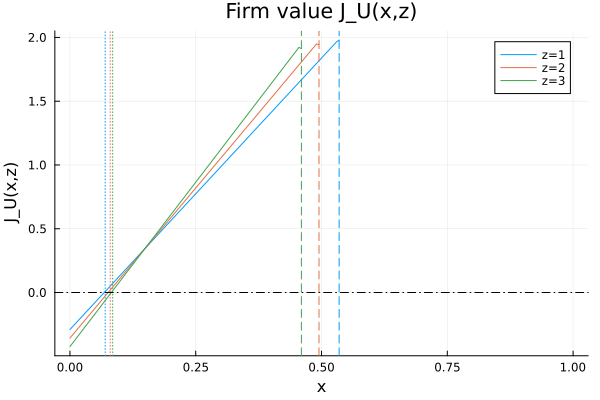

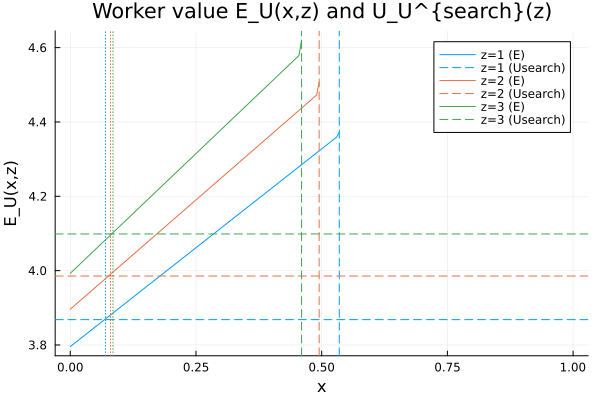

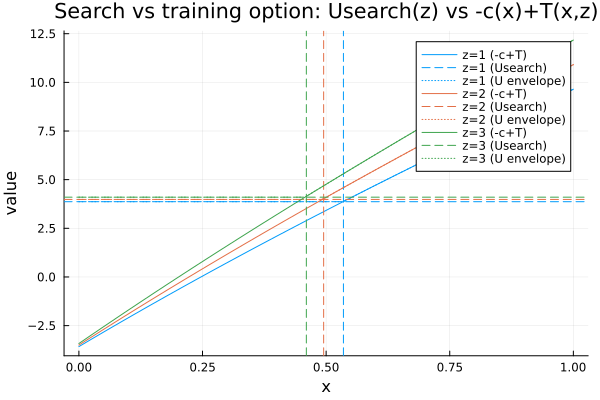

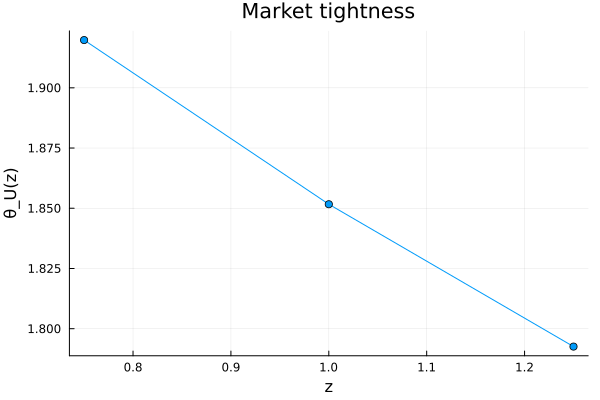

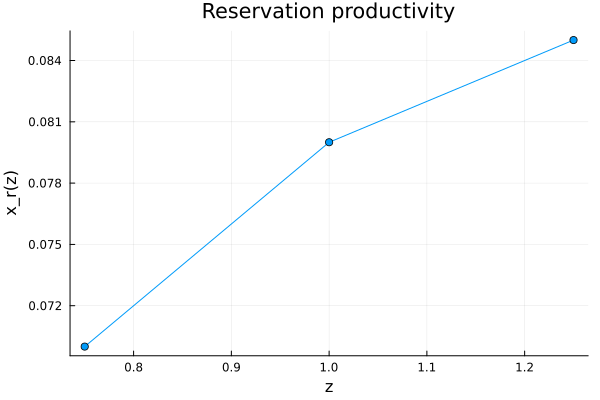

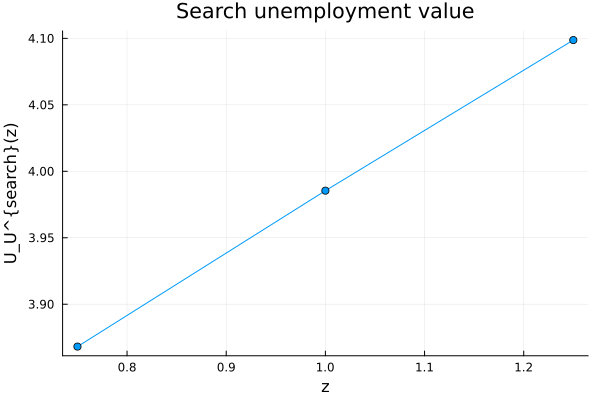

(plt1 = Plot{Plots.GRBackend() n=1}, plt2 = Plot{Plots.GRBackend() n=1}, plt3 = Plot{Plots.GRBackend() n=1})

In [14]:
plot_J(model)
plot_E(model)
plot_training_vs_search(model; show_envelope=true)
plot_equilibrium_objects(model; z_values=z_vals)